In [52]:
from scipy.stats import crystalball, norm, expon
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad



def g_s(X,beta,m,mu,sigma):
    pdf=crystalball(beta,m,loc=mu,scale=sigma)
    norm_factor = pdf.cdf(5)-pdf.cdf(0)
    trunc_pdf= pdf.pdf(X)/norm_factor
    return trunc_pdf


def h_s(Y,lam):
    pdf = expon(scale=1/lam)
    norm_factor = pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor
    return trunc_pdf

def g_b(X):
    pdf=1/5*np.ones_like(X)
    return pdf

def h_b(Y,mu_b,sigma_b):
    pdf = norm(loc=mu_b,scale=sigma_b)
    norm_factor=pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor  
    return trunc_pdf

def f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    pdf = f*g_s(X,beta,m,mu,sigma)*h_s(Y,lam)+(1-f)*g_b(X)*h_b(Y,mu_b,sigma_b)
    return pdf






In [53]:
mu_true = 3
sigma_true = 0.3
beta_true= 1
m_true = 1.4
f_true =0.6
lam_true=0.3
mu_b_true =0
sigma_b_true = 2.5


g_s_integral, g_s_error = quad(lambda x: g_s(x, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), 0, 5)
h_s_integral, h_s_error = quad(lambda x: h_s(x, lam=lam_true), 0, 10)
g_b_integral, g_b_error = quad(g_b, 0, 5)  # Assuming g_b doesn't need extra parameters
h_b_integral, h_b_error = quad(lambda x: h_b(x, mu_b=mu_b_true, sigma_b=sigma_b_true), 0, 10)

x_min=0
x_max=5
y_min=0 
y_max=10
# Print the results
print(f"Integral of g_s(x) from {x_min} to {x_max}: {g_s_integral:.6f} (Error estimate: {g_s_error:.6e})")
print(f"Integral of h_s(y) from {y_min} to {y_max}: {h_s_integral:.6f} (Error estimate: {h_s_error:.6e})")
print(f"Integral of g_b(x) from {x_min} to {x_max}: {g_b_integral:.6f} (Error estimate: {g_b_error:.6e})")
print(f"Integral of h_b(y) from {y_min} to {y_max}: {h_b_integral:.6f} (Error estimate: {h_b_error:.6e})")

Integral of g_s(x) from 0 to 5: 1.000000 (Error estimate: 7.289797e-09)
Integral of h_s(y) from 0 to 10: 1.000000 (Error estimate: 1.110223e-14)
Integral of g_b(x) from 0 to 5: 1.000000 (Error estimate: 1.110223e-14)
Integral of h_b(y) from 0 to 10: 1.000000 (Error estimate: 4.839198e-12)


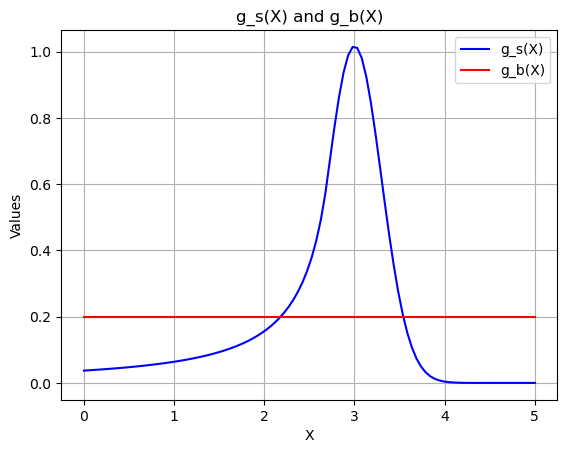

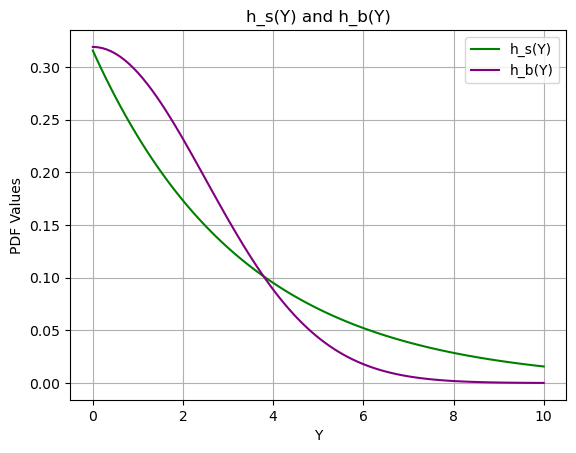

In [54]:



X=np.linspace(0,5,100)
Y=np.linspace(0,10,100)
plt.figure(1)  # First figure
plt.plot(X, g_s(X, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), label="g_s(X)", color='blue')
plt.plot(X, g_b(X), label="g_b(X)", color='red')
plt.title("g_s(X) and g_b(X)")
plt.xlabel("X")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Create the second figure for h_s(Y) and h_b(Y)
plt.figure(2)  # Second figure
plt.plot(Y, h_s(Y, lam=lam_true), label="h_s(Y)", color='green')
plt.plot(Y, h_b(Y, mu_b=mu_b_true, sigma_b=sigma_b_true), label="h_b(Y)", color='purple')
plt.title("h_s(Y) and h_b(Y)")
plt.xlabel("Y")
plt.ylabel("PDF Values")
plt.legend()
plt.grid(True)

# Show both figures
plt.show()

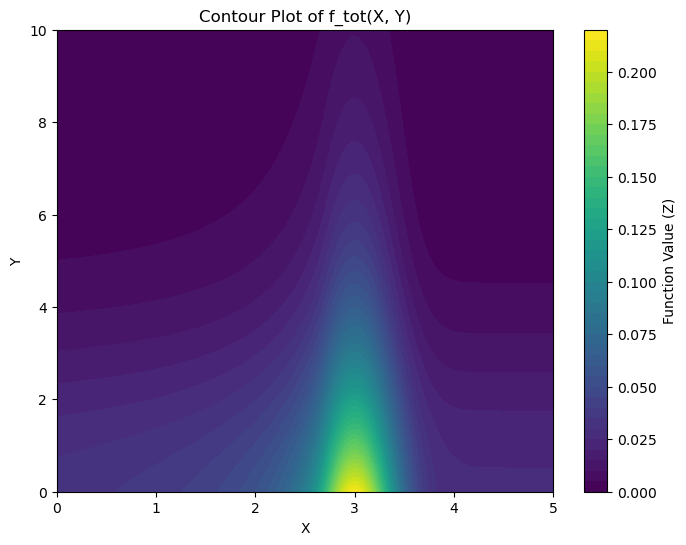

In [55]:


X, Y = np.meshgrid(X, Y)
Z = f_tot(X, Y, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)

# Alternatively, you can use a filled contour plot:
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value (Z)')
plt.title("Contour Plot of f_tot(X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [56]:

max_value = np.max(Z)

def accept_reject(N):  #change to batch generation
    accepted_points=[]
    rejected_points=[]
    with tqdm(total=N, desc="Sampling", unit="sample") as pbar:
        while len(accepted_points)<N:
            x=np.random.uniform(0, 5)
            y=np.random.uniform(0, 10)
            y_guess=np.random.uniform(0, max_value)
            y_val=f_tot(x,y,f=f_true,beta=beta_true,m=m_true,mu=mu_true,sigma=sigma_true,lam=lam_true,mu_b=mu_b_true,sigma_b=sigma_b_true)
            if y_guess<=y_val:
                accepted_points.append((x, y))
                pbar.update(1)  
            #else:    
                #rejected_points.append((x, y)) 

        
    return accepted_points


sample = accept_reject(100000)


Sampling:   1%|          | 577/100000 [00:05<17:12, 96.34sample/s] 


KeyboardInterrupt: 

In [93]:
def faster_event_generation(N):
    accepted_points = []
    
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points
    

sample = faster_event_generation(100000)   

        


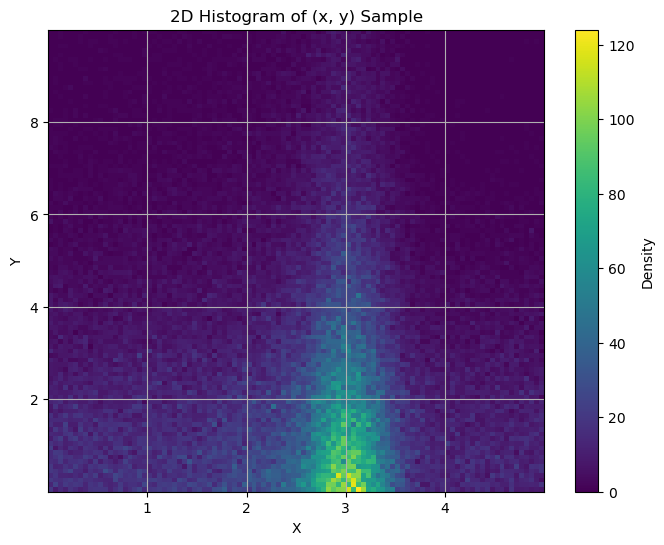

In [94]:
#saved_sample = np.array(sample)
x = sample[:, 0]
y = sample[:, 1]
plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=100, cmap='viridis')

# Add a colorbar to show the number of points in each bin
plt.colorbar(label='Density')

plt.title("2D Histogram of (x, y) Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [95]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

def density(data,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    #X=data[:,0]
    #Y=data[:,1]
    X,Y =data
    return N, N*f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b)

nll = ExtendedUnbinnedNLL(sample.T, density)

mi = Minuit(nll , N=100000, f=0.6 ,beta=1 ,m=1.4 ,mu=3 ,sigma=0.3 ,lam=0.3 ,mu_b=0.0 ,sigma_b=2.5)

mi.migrad()

mi.hesse()




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 289              │
│ EDM = 0.00142 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
│ 1 │ f       │   0.596   │   0.004   │            │            │         │         │       │
│ 2 │ beta    │   0.976   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.48    │   0.07    │            │            │         │         │       │
│ 4 │ mu      │  2.9984   │  0.0026   │            │            │         │         │       │
│ 5 │ sigma   │  0.2956   │  0.0024   │            │            │         │         │       │
│ 6 │ lam     │  0.2999   │  0.0021   │            │            │         │         │       │
│ 7 │ mu_b    │   -0.07   │   0.08    │            │            │         │         │       │
│ 8 │ sigma_b │   2.54    │   0.04    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │         N         f      beta         m        mu     sigma       lam      mu_b   sigma_b │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│       N │     1e+05  -9.5e-09 -6.61e-08  5.71e-08  1.76e-10 -1.25e-08 -1.64e-08  1.72e-06 -8.82e-07 │
│       f │  -9.5e-09  1.26e-05  7.63e-06 -8.75e-05 -2.48e-07  2.57e-06  1.84e-06   4.8e-05  -2.8e-05 │
│    beta │ -6.61e-08  7.63e-06  0.000478  -0.00124 -3.03e-05   2.5e-05  4.61e-07  7.02e-05  -4.6e-05 │
│       m │  5.71e-08 -8.75e-05  -0.00124   0.00436  5.82e-05 -5.38e-05  -1.2e-05 -0.000553  0.000344 │
│      mu │  1.76e-10 -2.48e-07 -3.03e-05  5.82e-05  6.81e-06 -3.58e-06 -5.93e-09 -2.18e-06  1.54e-06 │
│   sigma │ -1.25e-08  2.57e-06   2.5e-05 -5.38e-05 -3.58e-06  5.99e-06  3.81e-07  1.54e-05 -9.42e-06 │
│     lam │ -1.64e-08  1.84e-06  4.61e-07  -1.2e-05 -5.93e-09  3.81e-07  4.26e-06   9.9e-06  4.08e-06 │
│    mu_b │  1.72e-06   4.8e-05  7.02e-05 -0.000553 -2.18e-06  1.54e-05   9.9e-06   0.00661   -0.0028 │
│ sigma_b │ -8.82e-07  -2.8e-05  -4.6e-05  0.000344  1.54e-06 -9.42e-06  4.08e-06   -0.0028   0.00138 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

(100000, 2)


In [99]:
import timeit

def run_faster_event_generation():
    faster_event_generation(100000)

def run_normal_dist():
    np.random.normal(size=100000)

def run_fit():
    mi.migrad()

time_norm = timeit.timeit(run_normal_dist, number=100)
average_time_norm = time_norm / 100

time_gen = timeit.timeit(run_faster_event_generation, number=100)
average_time_gen = time_gen / 100
average_time_gen_rel=average_time_gen/average_time_norm

time_fit = timeit.timeit(run_fit, number=100)
average_time_fit = time_fit / 100
average_time_fit_rel=average_time_fit/average_time_norm



print(f"Average time for 100 runs of normal dist: {average_time_norm:.4f} seconds")
print(f"Average relative time for 100 runs of event generation: {average_time_gen_rel:.4f} ")
print(f"Average relative time for 100 runs of fitting: {average_time_fit_rel:.4f}")


Average time for 100 runs of normal dist: 0.0013 seconds
Average relative time for 100 runs of event generation: 107.0542 
Average relative time for 100 runs of fitting: 294.8313


In [153]:
from tqdm import tqdm 

def generate(N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    accepted_points = []
    N=int(N)
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f, beta, m, mu, sigma, lam, mu_b, sigma_b)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points


def fit(dset,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    nll = ExtendedUnbinnedNLL(dset.T, density)
    mi = Minuit(nll , N, f ,beta ,m ,mu ,sigma ,lam ,mu_b ,sigma_b)
    mi.migrad ()
    mi.hesse ()
    return mi

def fit_toys(Ntoy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    values =[]
    errors = []
    Num=np.random.poisson(sample_size)
    toys = [ generate(Num,f,beta,m,mu,sigma,lam,mu_b,sigma_b) for _ in range(Ntoy) ]
    for toy in tqdm(toys):
        mi_t = fit(toy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b)
        values.append( list(mi_t.values) )
        errors.append( list(mi_t.errors) )
    return values, errors






  3%|▎         | 8/250 [00:02<01:15,  3.20it/s]/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/27/607d42hs7jz87b8yg71lpk5r0000gn/T/ipykernel_93093/4277963234.py:11: RuntimeWarning: invalid value encountered in d

KeyboardInterrupt: 

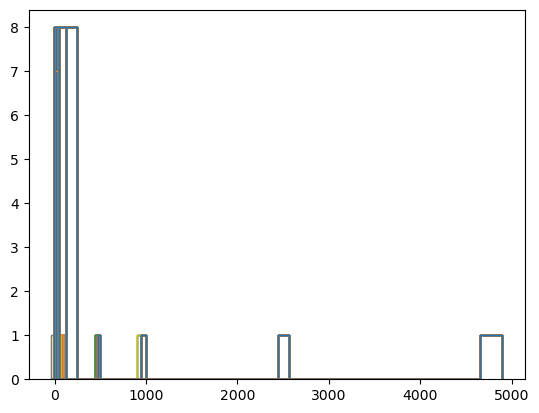

In [154]:

Ntoy = 250
sample_size_means=[500, 1000, 2500, 5000, 10000]

for size in sample_size_means:
    values, errors = fit_toys(Ntoy,size,*mi.values[1:])
    #plt.hist(values, bins=20, histtype='step', label=f"Sample size: {size}")


 



In [155]:
values ,errors = fit_toys(Ntoy,500,*mi.values[1:])


  0%|          | 1/250 [00:00<01:43,  2.41it/s]/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
  3%|▎         | 7/250 [00:03<02:10,  1.86it/s]/var/folders/27/607d42hs7jz87b8yg71lpk5r0000gn/T/ipykernel_93093/4277963234.py:11:

In [156]:
print(np.shape(values))

(250, 9)


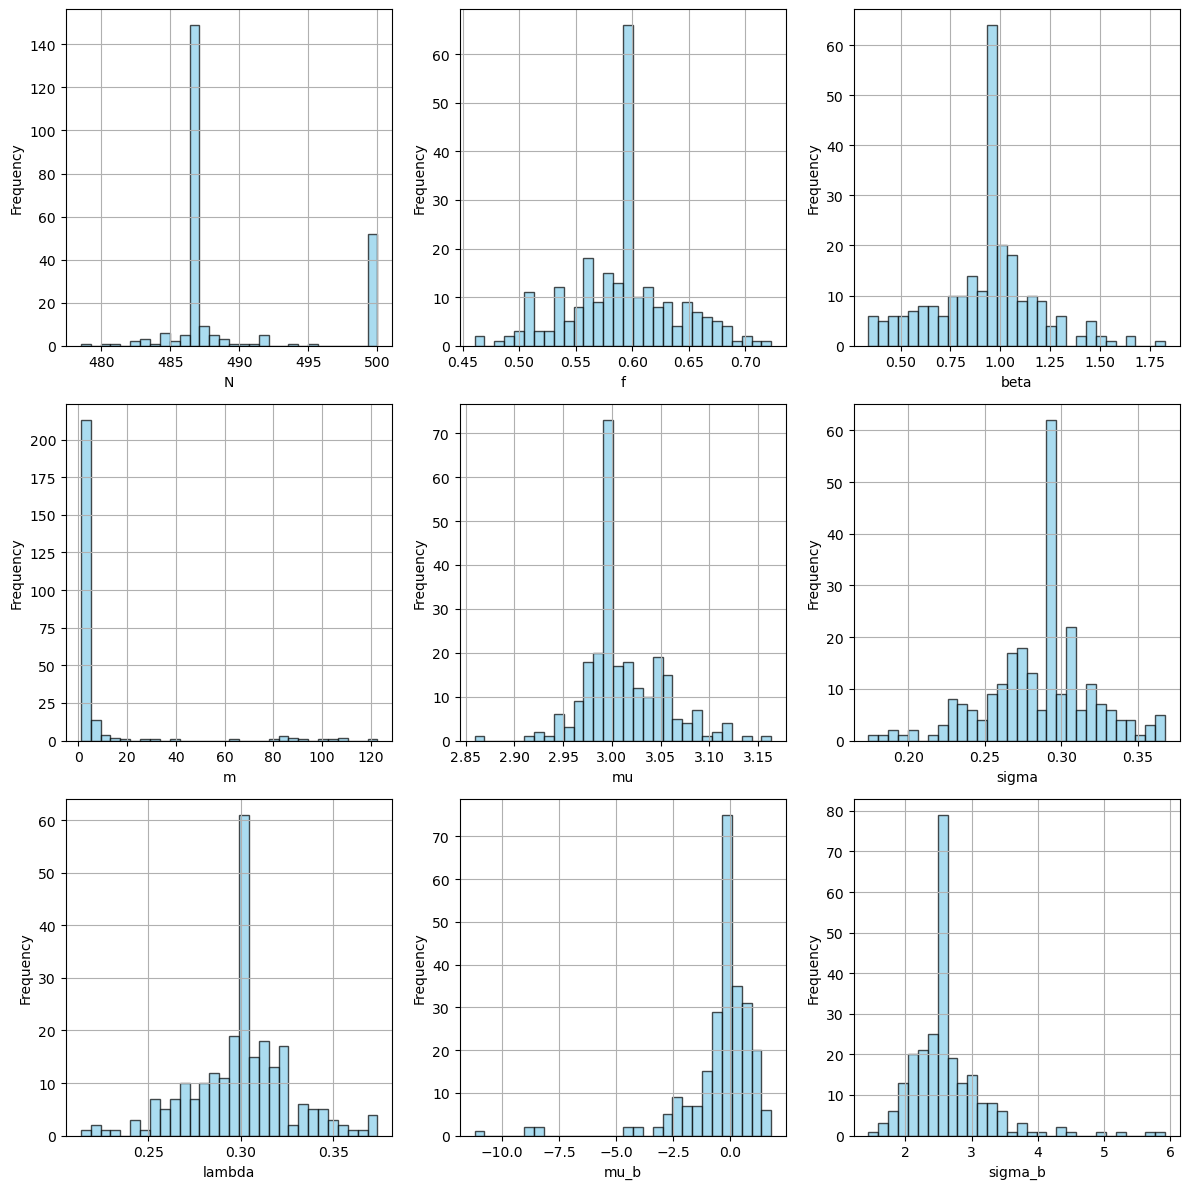

In [180]:

values = np.array(values)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 subplots
Names = ['N', 'f', 'beta', 'm', 'mu', 'sigma', 'lambda', 'mu_b', 'sigma_b']
# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Loop through each column (parameter) in the values array and plot a histogram
for i in range(9):
    axes[i].hist(values[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
     # Set the title for each subplot
    axes[i].set_xlabel(Names[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()